In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from sklearn import metrics

#Gerekli kütüphanelerin eklenmesi

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # training için device seçimi


transform_train = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
]) # girdilire yapılacak transform tipleri , bu örneğimiz için alexnete 28x28 verileri feedleyemediğimiz için 
   # 64x64'e çekmeye karar verdik.


train_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = True,
                                          transform = transform_train,
                                          download = True)

test_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = False,
                                          transform = transform_test) # torchvision package içerisinde , MNIST dataseti hazır olarak bulunmakta.
                                                                      # Basitçe değişkenlere atama yapıyoruz.


In [2]:
## HYPER PARAMETERS
batch_size = 100
learning_rate = 0.0003
num_epochs = 5
## HYPER PARAMETERS

In [3]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle = False)
# Datalarımızı batchlere bölmek ve training loopa sokmak için DataLoaderlare ihtiyacımız var.

model = models.alexnet(pretrained= True) ## Burdaki değere False vererek parametresiz bir Alexnet modeli getirebilirsiniz.
                                         ## Bazı notebooklarda tamamen kendimiz yazdığımız modellerde var.
for param in model.parameters():
    param.require_grad = False ## Son Layeri donduruyoruz. (Classifier Kısmını)

fc = nn.Sequential(
    nn.Linear(9216,4096),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
)

model.classifier = fc # Kendi amacımıza göre bir classifier takıyoruz modelin sonuna.

In [4]:
criterion = nn.CrossEntropyLoss() # Error belirlenmesi için bir metrik tutmalıyız.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) ##Optimizer Değiştirilebilir farklı sonuçlar için.

model.to(device) ## Modeli GPU'ya atıyoruz.

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_featur

In [5]:
padding = Variable(torch.zeros(100, 2, 64, 64)) # Genelde torchvision kütüphanesindeki modeller 3 channel image kabul ediyor.
                                                # Bizim inputlarımız 1 channel olduğu için size mismatch hatası alıyoruz.
                                                # Basit bir şekilde loopun en başında padding ile (3x28x28) bir resim elde edebiliriz.

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = torch.cat((images, padding), 1) ## padding ile image birleştirilir.
        images = images.to(device) ## image GPU'ya atılır
        labels = labels.to(device) ## label GPU'ya atılır
        
        outputs = model(images) ## image forward()'a  girer.
        loss = criterion(outputs, labels) ## Loss hesaplanır.
        
        optimizer.zero_grad() # optimizer sıfırlanır.
        loss.backward() # backprop
        optimizer.step() #parametler yenilernir.
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item())) # Log işlemi

Epoch [1/5], Step [100/600], Loss: 0.1791
Epoch [1/5], Step [200/600], Loss: 0.1644
Epoch [1/5], Step [300/600], Loss: 0.1629
Epoch [1/5], Step [400/600], Loss: 0.0459
Epoch [1/5], Step [500/600], Loss: 0.1161
Epoch [1/5], Step [600/600], Loss: 0.1424
Epoch [2/5], Step [100/600], Loss: 0.2548
Epoch [2/5], Step [200/600], Loss: 0.1300
Epoch [2/5], Step [300/600], Loss: 0.0170
Epoch [2/5], Step [400/600], Loss: 0.0390
Epoch [2/5], Step [500/600], Loss: 0.0415
Epoch [2/5], Step [600/600], Loss: 0.0488
Epoch [3/5], Step [100/600], Loss: 0.1023
Epoch [3/5], Step [200/600], Loss: 0.0968
Epoch [3/5], Step [300/600], Loss: 0.0107
Epoch [3/5], Step [400/600], Loss: 0.0473
Epoch [3/5], Step [500/600], Loss: 0.0584
Epoch [3/5], Step [600/600], Loss: 0.0112
Epoch [4/5], Step [100/600], Loss: 0.1020
Epoch [4/5], Step [200/600], Loss: 0.0142
Epoch [4/5], Step [300/600], Loss: 0.0713
Epoch [4/5], Step [400/600], Loss: 0.0654
Epoch [4/5], Step [500/600], Loss: 0.0076
Epoch [4/5], Step [600/600], Loss:

In [6]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # Predicted ile orjinal label eşitse doğru kabul ediyoruz.
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)
    print(correct)
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

9844
Test Accuracy of the model on the 10000 test images: 98.44 %


In [7]:
#Bu Loader sadece Confusion matrix gösterimi için bulunmaktadır, bütün datalar tek batchde geçer, ama conf matrix için en basit yollardan biri.
confusion_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= 10000, shuffle = False)

padding = Variable(torch.zeros(10000, 2, 64, 64))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in confusion_loader:
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)

In [8]:
print(f"The Accuracy : { 100 * metrics.accuracy_score(lb, pred)}")
print(f"The Precision : {100 * metrics.precision_score(lb, pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(lb, pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(lb, pred, average = 'macro')}")

The Accuracy : 98.44000000000001
The Precision : 98.41842628318649
The Recall : 98.44894384443096
The F1 Score : 98.4223715198817


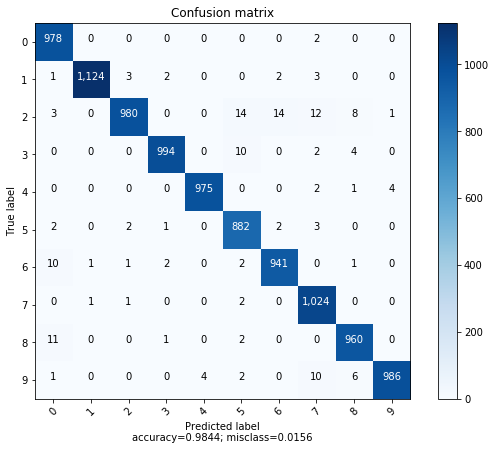

None


In [10]:
from cm_helper import plot_confusion_matrix

conf_matrix = metrics.confusion_matrix(lb, pred)
print(plot_confusion_matrix(conf_matrix,normalize =False,target_names=[0,1,2,3,4,5,6,7,8,9]))